---
title: Finite Difference
suptitle: Part I - Slicing
short_title: Finite Difference with Slicing Operations
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

**Jax Methods**

* Loops
* Scanning
* Convolutions
* Stencils

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

TypeError: here() got an unexpected keyword argument 'project_files'

In [15]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [8]:
import finitediffx as fdx
from jaxsw._src.operators.functional.fd import difference

In [13]:
x, y = [jnp.linspace(0, 1, 100)] * 2
dx, dy = x[1] - x[0], y[1] - y[0]
X, Y = jnp.meshgrid(x, y, indexing="ij")
F =  jnp.sin(X) * jnp.cos(Y)
dFdX = fdx.difference(F, step_size=dx, axis=0, accuracy=3)
dFdXdY = fdx.difference(dFdX, step_size=dy, axis=1, accuracy=3)

x = jnp.array([1.2, 1.3, 2.2, 3., 4.5, 5.5, 6., 7., 8., 20.])
difference(x, accuracy=1)

Array([ 0.0999999 ,  0.9000001 ,  0.79999995,  1.5       ,  1.        ,
        0.5       ,  1.        ,  1.        , 12.        , 12.        ],      dtype=float32)

In [14]:
x, y = [jnp.linspace(0, 1, 100)] * 2
dx, dy = x[1] - x[0], y[1] - y[0]
X, Y = jnp.meshgrid(x, y, indexing="ij")
F =  jnp.sin(X) * jnp.cos(Y)
dFdX = difference(F, step_size=dx, axis=0, accuracy=3, method="central")
dFdXdY = difference(dFdX, step_size=dy, axis=1, accuracy=3, method="central")

x = jnp.array([1.2, 1.3, 2.2, 3., 4.5, 5.5, 6., 7., 8., 20.])
difference(x, accuracy=1)

Array([ 0.0999999 ,  0.9000001 ,  0.79999995,  1.5       ,  1.        ,
        0.5       ,  1.        ,  1.        , 12.        , 12.        ],      dtype=float32)

$$
\vec{\mathbf{x}}= 
\begin{bmatrix}
x \\ y
\end{bmatrix}
$$

$$
\boldsymbol{f}(x,y) = \sin(x)\cos(y)
$$

In [4]:
# dydx of a 2D array
x, y = [jnp.linspace(0, 1, 100)] * 2
dx, dy = x[1] - x[0], y[1] - y[0]
X, Y = jnp.meshgrid(x, y, indexing="ij")
F =  jnp.sin(X) * jnp.cos(Y)
dFdX_analytical = jnp.cos(Y) * jnp.cos(X)
dFdY_analytical = - jnp.sin(X) * jnp.sin(Y)

$$
\partial_x \boldsymbol{f}(x,y) = \cos(y)\cos(x)
$$

$$
\partial_x \boldsymbol{f}(x,y) = -\sin(x)\cos(y)
$$

In [56]:
from jaxsw._src.operators.functional.fd import difference, gradient

step_size = dx
accuracy = 4
method = "central"
mode = "edge"
dFdX = difference(
    array=F,
    axis=0,
    step_size=step_size,
    accuracy=accuracy,
    method=method
)
dFdY = difference(
    array=F,
    axis=1,
    step_size=step_size,
    accuracy=accuracy,
    method=method
)

print(f"F: {F.shape}")
print(f"dFdX: {dFdX.shape}")
print(f"dFdY: {dFdY.shape}")

F: (100, 100)
dFdX: (100, 100)
dFdY: (100, 100)


In [57]:
dFdY_analytical.max(), dFdY_analytical.min()

(Array(-0., dtype=float32), Array(-0.7080735, dtype=float32))

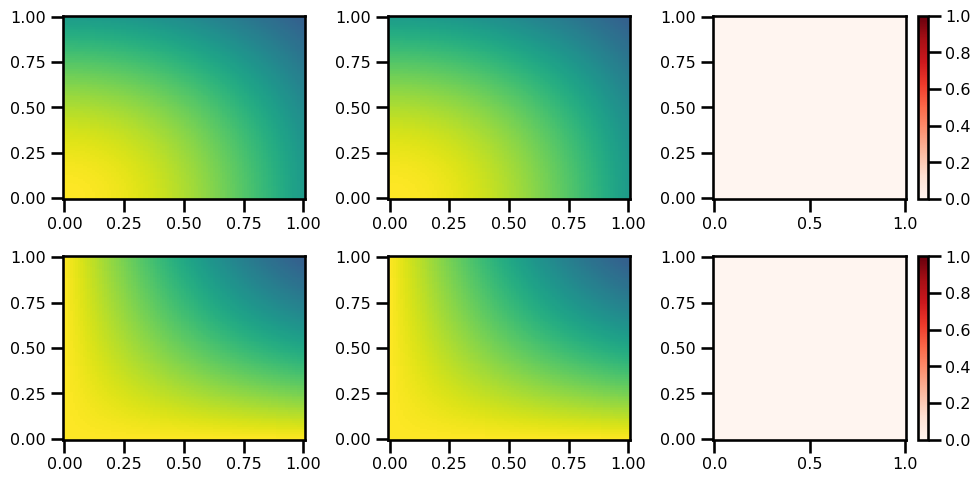

In [64]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

ax[0, 0].pcolormesh(X,Y, dFdX, vmin=0.0, vmax=1.0)
ax[0, 1].pcolormesh(X,Y, dFdX_analytical, vmin=0.0, vmax=1.0)
pts = ax[0, 2].pcolormesh(X,Y,np.abs(dFdX-dFdX_analytical), cmap="Reds", vmin=0.0, vmax=1.0)
plt.colorbar(pts)

ax[1, 0].pcolormesh(X,Y, dFdY, vmin=-1.0, vmax=0.0)
ax[1, 1].pcolormesh(X,Y, dFdY_analytical, vmin=-1.0, vmax=0.0)
pts = ax[1, 2].pcolormesh(X,Y,np.abs(dFdY-dFdY_analytical),  cmap="Reds", vmin=0.0, vmax=1.0)


plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Gradient

In [68]:
x, y = [jnp.linspace(-1,1,50)] * 2
dx, dy = [x[1]-x[0]] * 2

X, Y = jnp.meshgrid(x,y,indexing="ij")

F1 = X**2 + Y**3 #-Y
F2 = X**4 + Y**3 #+X
F = jnp.stack([F1,F2], axis=0)
dF1dX_analytical = 2*X
dF2dY_analytical = 3*Y**2
gradF_analytical = jnp.stack([dF1dX, dF2dY], axis=0)

In [69]:
from jaxsw._src.operators.functional.fd import difference, gradient

step_size = dx
accuracy = 4
method = "central"
mode = "edge"
dF1dX = difference(
    array=F1,
    axis=0,
    step_size=step_size,
    accuracy=accuracy,
    method=method
)
dF2dY = difference(
    array=F2,
    axis=1,
    step_size=step_size,
    accuracy=accuracy,
    method=method
)

print(f"F: {F.shape}")
print(f"dFdX: {dF1dX.shape}")
print(f"dFdY: {dF2dY.shape}")

F: (2, 50, 50)
dFdX: (50, 50)
dFdY: (50, 50)


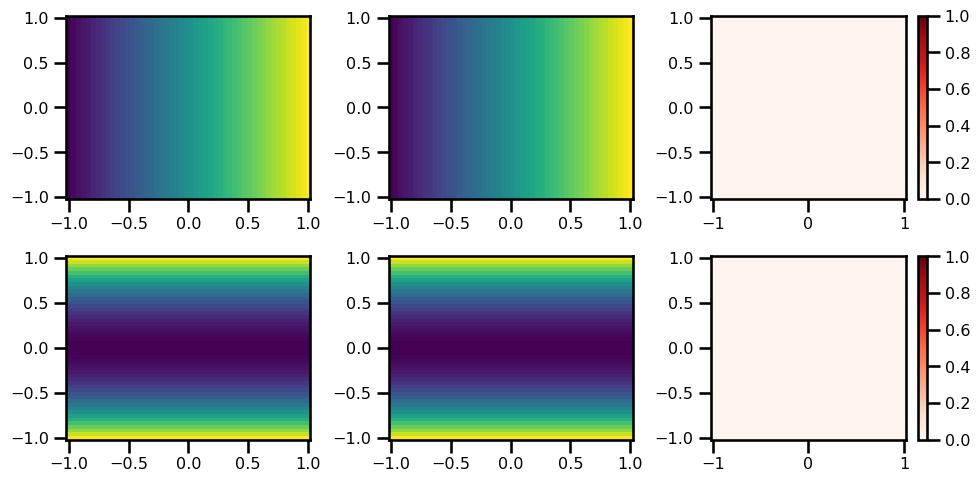

In [73]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

ax[0, 0].pcolormesh(X,Y, dF1dX)
ax[0, 1].pcolormesh(X,Y, dF1dX_analytical)
pts = ax[0, 2].pcolormesh(X,Y,np.abs(dF1dX-dF1dX_analytical), cmap="Reds", vmin=0.0, vmax=1.0)
plt.colorbar(pts)

ax[1, 0].pcolormesh(X,Y, dF2dY)
ax[1, 1].pcolormesh(X,Y, dF2dY_analytical)
pts = ax[1, 2].pcolormesh(X,Y,np.abs(dF2dY-dF2dY_analytical),  cmap="Reds", vmin=0.0, vmax=1.0)


plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [ ]:
x, y = [jnp.linspace(-1,1,50)] * 2
dx, dy = [x[1]-x[0]] * 2

X, Y = jnp.meshgrid(x,y,indexing="ij")

F1 = X**2 + Y**3 #-Y
F2 = X**4 + Y**3 #+X
F = jnp.stack([F1,F2], axis=0)
dF1dX_analytical = 2*X
dF2dY_analytical = 3*Y**2
gradF_analytical = jnp.stack([dF1dX, dF2dY], axis=0)

In [76]:
F.shape, F1.shape

((2, 50, 50), (50, 50))

In [75]:
from jaxsw._src.operators.functional.fd import difference, gradient

step_size = (dx, dy)
accuracy = 4
method = "central"
mode = "edge"
gradF = gradient(
    array=F1,
    step_size=step_size,
    accuracy=accuracy,
    method=method
)

print(f"F: {F.shape}")
print(f"dFdX: {gradF.shape}")

F: (2, 50, 50)
dFdX: (2, 50, 50)


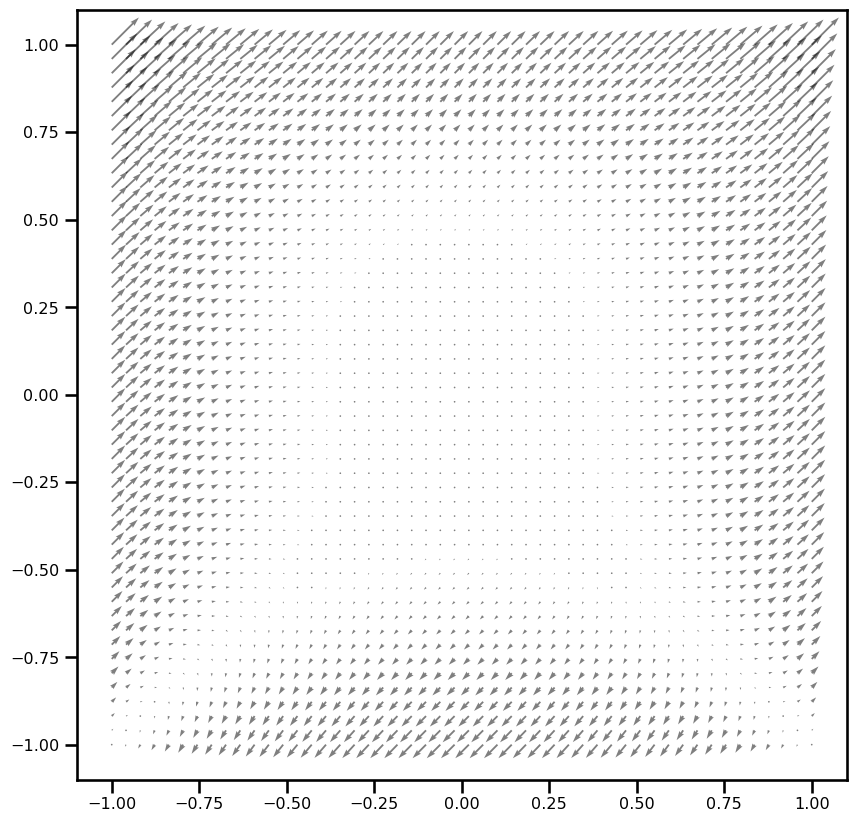

In [4]:
fig, ax = plt.subplots(figsize=(10,10))

ax.quiver(X, Y, F1, F2, color="k", alpha=0.5)

ax.set_aspect('equal', 'box')
plt.show()

In [78]:
from jaxsw._src.operators.functional.fd import difference, gradient, jacobian

step_size = (dx, dy)
accuracy = 4
method = "central"
mode = "edge"
JacobianF = jacobian(
    array=F,
    step_size=step_size,
    accuracy=accuracy,
    method=method
)

print(f"F: {F.shape}")
print(f"Jacobian F: {JacobianF.shape}")

F: (2, 50, 50)
Jacobian F: (2, 2, 50, 50)


In [84]:
from jaxsw._src.operators.functional.fd import difference, gradient, jacobian, divergence

step_size = (dx, dy)
accuracy = 4
method = "central"
mode = "edge"
divF = divergence(
    array=F,
    step_size=step_size,
    accuracy=accuracy,
    method=method, 
    keepdims=False
)

print(f"F: {F.shape}")
print(f"Div F: {divF.shape}")

F: (2, 50, 50)
Div F: (50, 50)


In [87]:
from jaxsw._src.operators.functional.fd import difference, gradient, jacobian, divergence, laplacian

step_size = (dx, dy)
accuracy = 4
method = "central"
mode = "edge"
lapF = laplacian(
    array=F1,
    step_size=step_size,
    accuracy=accuracy,
    method=method
)

print(f"F: {F.shape}")
print(f"Laplacian F: {lapF.shape}")

F: (2, 50, 50)
Laplacian F: (50, 50)
